## Pre-process scraped data

In [26]:
import pandas as pd 
import re
import os 
from ast import literal_eval
from collections import Counter, defaultdict
import numpy as np 
from typing import Dict, List, Set, Tuple
from copy import deepcopy
from pychord import Chord, QualityManager
import random
from model_helpers import preprocess_text

### 1. Construct dataframe of all songs

In [27]:
genres = os.listdir('scrapped_data')
all_genres = pd.DataFrame()
for genre in genres:
    basepath = f'./scrapped_data/{genre}/'
    filepaths = [basepath + f for f in os.listdir(f'./scrapped_data/{genre}/') if f.endswith('.csv')]
    genre_df = pd.concat(map(pd.read_csv, filepaths))
    genre_df['genre'] = genre
    all_genres = pd.concat([all_genres, genre_df], ignore_index=True).drop(columns='Unnamed: 0')
all_genres

,name,author,link,lyrics,chords,genre
0,As Long As The Grass Shall Grow,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"As long, As the moon shall rise, As ...","['A', 'E', 'A', 'A', 'E', 'A', 'D', 'D', 'A', ...",Country
1,Delias Gone (ver 4),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Delia, oh, Delia Delia all my life\r\nIf I had...","['A', 'D', 'A', 'A7', 'D', 'B7', 'E', 'A', 'D'...",Country
2,Mean Eyed Cat,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['E', 'B7', 'E', 'A7', 'B7', 'E', 'E', 'B7', '...",Country
3,Mean Eyed Cat (ver 2),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['C', 'G7', 'C', 'F', 'G7', 'C', 'F', 'C', 'F'...",Country
4,Mean Eyed Cat (ver 3),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I give my woman half my money at the general s...,"['F', 'C', 'F', 'Ab', 'Bb', 'C', 'Fm', 'F', 'F...",Country
...,...,...,...,...,...,...
46923,Fake Love Dont Last,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,"I watched a movie scene, got déjà vu\r\n'Cause...","['Em', 'G', 'B', 'C', 'Em', 'G', 'B', 'C', 'Em...",Rock
46924,Sid And Nancy,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,I knew a girl who'd wear my t-shirts when she ...,"['D', 'F#m', 'E', 'D', 'F#m', 'E', 'D', 'F#m',...",Rock
46925,Forever,Stereophonics,https://tabs.ultimate-guitar.com/tab/stereopho...,Sun beats down on my mind on a friday morning...,"['G', 'C', 'G', 'C', 'G', 'C', 'G', 'C', 'D', ...",Rock
46926,Goodnight Chicago,Rainbow Kitten Surprise,https://tabs.ultimate-guitar.com/tab/rainbow-k...,Twenty years to see New York reflected on subw...,"['C', 'C', 'Am', 'F', 'C', 'C', 'C', 'Am', 'F'...",Rock


### 2. Remove duplicates

Parse real name of a song i.e. remove the version. Notice song on index 7 and 8.

In [28]:
all_genres['actual_name'] = all_genres.name.apply(lambda name : name.split(' (ver')[0])
all_genres.head(10)

,name,author,link,lyrics,chords,genre,actual_name
0,As Long As The Grass Shall Grow,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"As long, As the moon shall rise, As ...","['A', 'E', 'A', 'A', 'E', 'A', 'D', 'D', 'A', ...",Country,As Long As The Grass Shall Grow
1,Delias Gone (ver 4),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Delia, oh, Delia Delia all my life\r\nIf I had...","['A', 'D', 'A', 'A7', 'D', 'B7', 'E', 'A', 'D'...",Country,Delias Gone
2,Mean Eyed Cat,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['E', 'B7', 'E', 'A7', 'B7', 'E', 'E', 'B7', '...",Country,Mean Eyed Cat
3,Mean Eyed Cat (ver 2),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['C', 'G7', 'C', 'F', 'G7', 'C', 'F', 'C', 'F'...",Country,Mean Eyed Cat
4,Mean Eyed Cat (ver 3),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I give my woman half my money at the general s...,"['F', 'C', 'F', 'Ab', 'Bb', 'C', 'Fm', 'F', 'F...",Country,Mean Eyed Cat
5,I Couldnt Keep From Crying,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"I SAW YOU WALKING BY HIS SIDE,\r\nHEARD YOU W...","['A', 'A7', 'D', 'A', 'E7', 'A', 'A7', 'D', 'A...",Country,I Couldnt Keep From Crying
6,It Aint Me Babe (ver 3),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,Go 'way from my window leave at your own chose...,"['A', 'Bm', 'A', 'E', 'A', 'A', 'Bm', 'A', 'E'...",Country,It Aint Me Babe
7,Wildwood Flower,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,Oh I’ll twine with my mingles of raven black h...,"['E', 'B', 'E', 'E', 'B', 'E', 'E', 'A', 'E', ...",Country,Wildwood Flower
8,Im So Lonesome I Could Cry,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Hear that / lonesome / Whipoor - / will,\r\nHe...","['C', 'Am', 'C', 'C', 'Am', 'C', 'C7', 'F', 'A...",Country,Im So Lonesome I Could Cry
9,Truck Driving Man,Glen Campbell,https://tabs.ultimate-guitar.com/tab/glen-camp...,"Well I stopped at a roadhouse in Texas, with a...","['G', 'C', 'G', 'D', 'G', 'G7', 'C', 'D', 'D7'...",Country,Truck Driving Man


In [29]:
print(all_genres.actual_name.value_counts())
all_genres.loc[all_genres.actual_name.str.contains('What A Wonderful World')].head(10)

What A Wonderful World             39
Georgia On My Mind                 37
Crazy                              33
Cant Take My Eyes Off You          33
Easy                               31
                                   ..
Never Wanna Fall In Love With U     1
Oh What It Seemed To Be             1
Lous Got The Flu                    1
Daisy                               1
Goodnight Chicago                   1
Name: actual_name, Length: 27285, dtype: int64


,name,author,link,lyrics,chords,genre,actual_name
12226,What A Wonderful World,Stacey Kent,https://tabs.ultimate-guitar.com/tab/stacey-ke...,"I see trees of green, red roses too\r\n ...","['A', 'C#m7', 'Dmaj7', 'C#m7', 'Bm7', 'A', 'C#...",Jazz,What A Wonderful World
12433,What A Wonderful World (ver 9),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\nI see t...","['C', 'Em', 'F', 'Em', 'Dm', 'C', 'E7', 'Am', ...",Jazz,What A Wonderful World
12438,What A Wonderful World (ver 2),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\n I...","['F', 'Am', 'Bb', 'Am', 'Gm7', 'F', 'A7', 'Dm'...",Jazz,What A Wonderful World
12448,What A Wonderful World,Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\n ...","['F', 'Am', 'Bb', 'Am', 'Gm', 'F', 'A7', 'Dm',...",Jazz,What A Wonderful World
12461,What A Wonderful World (ver 3),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\nI see t...","['G', 'Bm', 'C', 'Bm', 'Am7', 'G', 'B7', 'Em',...",Jazz,What A Wonderful World
12474,What A Wonderful World (ver 11),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\nI see t...","['C', 'G', 'Am', 'Em', 'Dm', 'C', 'E7', 'Am', ...",Jazz,What A Wonderful World
12478,What A Wonderful World (ver 4),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\nI see t...","['F', 'Am', 'Bb', 'Am', 'Gm7', 'F', 'A7', 'Dm'...",Jazz,What A Wonderful World
12577,What A Wonderful World,Willie Nelson,https://tabs.ultimate-guitar.com/tab/willie-ne...,"I see trees of green, red roses too\r\nI see t...","['D', 'F#m', 'G', 'F#m', 'Em', 'D', 'F#7', 'Bm...",Jazz,What A Wonderful World
12779,What A Wonderful World (ver 14),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too,\r\nI see ...","['C', 'G', 'Am', 'Em', 'F', 'Em', 'Dm', 'Am', ...",Jazz,What A Wonderful World
12790,What A Wonderful World (ver 7),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\nI see t...","['C', 'Em', 'F', 'Em', 'Dm7', 'C', 'E7', 'Am',...",Jazz,What A Wonderful World


Remove duplicate songs that have the same name, have same author, but in different versions.

In [30]:
all_genres_unique = all_genres.drop_duplicates(subset=['actual_name', 'author', 'genre']).reset_index()
all_genres_unique

,index,name,author,link,lyrics,chords,genre,actual_name
0,0,As Long As The Grass Shall Grow,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"As long, As the moon shall rise, As ...","['A', 'E', 'A', 'A', 'E', 'A', 'D', 'D', 'A', ...",Country,As Long As The Grass Shall Grow
1,1,Delias Gone (ver 4),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Delia, oh, Delia Delia all my life\r\nIf I had...","['A', 'D', 'A', 'A7', 'D', 'B7', 'E', 'A', 'D'...",Country,Delias Gone
2,2,Mean Eyed Cat,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['E', 'B7', 'E', 'A7', 'B7', 'E', 'E', 'B7', '...",Country,Mean Eyed Cat
3,5,I Couldnt Keep From Crying,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"I SAW YOU WALKING BY HIS SIDE,\r\nHEARD YOU W...","['A', 'A7', 'D', 'A', 'E7', 'A', 'A7', 'D', 'A...",Country,I Couldnt Keep From Crying
4,6,It Aint Me Babe (ver 3),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,Go 'way from my window leave at your own chose...,"['A', 'Bm', 'A', 'E', 'A', 'A', 'Bm', 'A', 'E'...",Country,It Aint Me Babe
...,...,...,...,...,...,...,...,...
34360,46922,5150,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,Bruises don't heal overnight\r\nI'm a few sips...,"['C', 'G', 'D', 'Em', 'C', 'G', 'D', 'Em', 'C'...",Rock,5150
34361,46923,Fake Love Dont Last,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,"I watched a movie scene, got déjà vu\r\n'Cause...","['Em', 'G', 'B', 'C', 'Em', 'G', 'B', 'C', 'Em...",Rock,Fake Love Dont Last
34362,46924,Sid And Nancy,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,I knew a girl who'd wear my t-shirts when she ...,"['D', 'F#m', 'E', 'D', 'F#m', 'E', 'D', 'F#m',...",Rock,Sid And Nancy
34363,46925,Forever,Stereophonics,https://tabs.ultimate-guitar.com/tab/stereopho...,Sun beats down on my mind on a friday morning...,"['G', 'C', 'G', 'C', 'G', 'C', 'G', 'C', 'D', ...",Rock,Forever


Notice some songs are performed by different artists and should also be removed based on the lyrics I guess. See example:

In [31]:
print(all_genres_unique.actual_name.value_counts())
all_genres_unique.loc[all_genres_unique.actual_name.str.contains('What a wonderful world', flags=re.IGNORECASE)].head(10)

Without You               16
Home                      16
Stay                      16
Run                       15
Heaven                    15
                          ..
The New Breed              1
The Weather In My Head     1
Planet Drhonda             1
Slinky Thing               1
Goodnight Chicago          1
Name: actual_name, Length: 27285, dtype: int64


,index,name,author,link,lyrics,chords,genre,actual_name
9457,12226,What A Wonderful World,Stacey Kent,https://tabs.ultimate-guitar.com/tab/stacey-ke...,"I see trees of green, red roses too\r\n ...","['A', 'C#m7', 'Dmaj7', 'C#m7', 'Bm7', 'A', 'C#...",Jazz,What A Wonderful World
9657,12433,What A Wonderful World (ver 9),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,"I see trees of green, red roses too\r\nI see t...","['C', 'Em', 'F', 'Em', 'Dm', 'C', 'E7', 'Am', ...",Jazz,What A Wonderful World
9756,12577,What A Wonderful World,Willie Nelson,https://tabs.ultimate-guitar.com/tab/willie-ne...,"I see trees of green, red roses too\r\nI see t...","['D', 'F#m', 'G', 'F#m', 'Em', 'D', 'F#7', 'Bm...",Jazz,What A Wonderful World
10305,13308,What A Wonderful World,Eva Cassidy,https://tabs.ultimate-guitar.com/tab/eva-cassi...,"I see trees that are green, and red roses too...","['D', 'D7M', 'G', 'D', 'Em', 'D', 'F#', 'Bm', ...",Jazz,What A Wonderful World
11127,14381,What A Wonderful World,Jon Batiste,https://tabs.ultimate-guitar.com/tab/jon-batis...,"I see trees of green, red roses too\r\nI see t...","['E', 'A', 'E', 'Asus2', 'Asus2', 'E', 'C#m', ...",Jazz,What A Wonderful World
11374,14703,What A Wonderful World (ver 5),Louis Armstrong,https://tabs.ultimate-guitar.com/tab/louis-arm...,I see trees of green red roses too\r\nI see th...,"['G', 'D', 'Am7', 'G', 'C', 'G', 'D', 'A7sus',...",Pop,What A Wonderful World
16195,20763,Somewhere Over The Rainbow What A Wonderful World,Robin Schulz,https://tabs.ultimate-guitar.com/tab/robin-sch...,Somewhere over the rainbow\r\n Bluebirds fly\...,"['C', 'Em', 'F', 'C', 'F', 'C', 'G', 'Am', 'F'...",Pop,Somewhere Over The Rainbow What A Wonderful World
32948,44359,What A Wonderful World,Joey Ramone,https://tabs.ultimate-guitar.com/tab/joey-ramo...,"I see trees of green / Red roses, too / I see ...","['F', 'Am', 'Bb', 'Am', 'Gm', 'F', 'A7', 'Dm',...",Rock,What A Wonderful World


### 3. Remove non-English songs

In [32]:
from langdetect import detect_langs, detect

def get_lang(text):
    print(f'{text} -- {detect_langs(text)}')
    print(detect(text))
get_lang('Hello')
get_lang('hi what is up')
get_lang('bonjour comment ca va')
get_lang('hej vad gör du här ens')

Hello -- [no:0.5568898975767852, fi:0.4431101024232147]
fi
hi what is up -- [en:0.8571420742823269, sw:0.14285719205457323]
en
bonjour comment ca va -- [fr:0.9999962394308746]
fr
hej vad gör du här ens -- [sv:0.9999979787281408]
sv


In [33]:
print(all_genres_unique.iloc[0, :].lyrics[:20])

     As long,  As th


In [34]:
detect_langs(all_genres_unique.iloc[0, :].lyrics[20:])

[en:0.9999959536030955]

In [35]:
def get_lang(text):
    try:
        language = detect(text)
    except:
        language = 'not identified'
    return language
all_genres_unique['language'] = all_genres_unique['lyrics'].apply(lambda lyrics : get_lang(lyrics[:200]))

In [36]:
all_genres_unique.loc[all_genres_unique.language == 'not identified']

,index,name,author,link,lyrics,chords,genre,actual_name,language
1328,1389,Are You Sure,Willie Nelson,https://tabs.ultimate-guitar.com/tab/willie-ne...,_________2_\r\n_________3_|\r\n_________2_\r\n,"['D', 'G', 'D/F#']",Country,Are You Sure,not identified
3495,3948,Some Go Home,Jerry Jeff Walker,https://tabs.ultimate-guitar.com/tab/jerry-jef...,#\r\n#\r\n#\r\n,"['C', 'G', 'D', 'Dsus4', 'D', 'C', 'Dsus4', 'D...",Country,Some Go Home,not identified
9429,12195,Hang Em High,Booker T. & the M.G.'s,https://tabs.ultimate-guitar.com/tab/booker-t-...,\r\n \r\n \r\n ...,"['Em', 'D', 'Em', 'D', 'Em', 'D', 'Em', 'A', '...",Jazz,Hang Em High,not identified
9684,12484,Europa,Santana,https://tabs.ultimate-guitar.com/tab/santana/e...,|--------|\r\n|--------|--------|--------|----...,"['Bb7sus4', 'Bb7', 'Ebmaj7', 'Abmaj7', 'G7sus4...",Jazz,Europa,not identified
9974,12867,The Shaker Song,The Manhattan Transfer,https://tabs.ultimate-guitar.com/tab/the-manha...,* * * * * * * * * * * *...,"['G6', 'G11', 'G6', 'G11', 'G6', 'G11', 'G6', ...",Jazz,The Shaker Song,not identified
10088,13016,Igy,Donald Fagen,https://tabs.ultimate-guitar.com/tab/donald-fa...,* * * * * * * * * ...,"['Abm', 'Dbm9', 'Emaj9', 'E/F#', 'Abm', 'Dbm9'...",Jazz,Igy,not identified
10458,13515,La Fiesta,Chick Corea,https://tabs.ultimate-guitar.com/tab/chick-cor...,|--=--=--+--=--=--+--=--=--+--=--=--+--=--=--+...,"['AMaj7', 'Db7', 'DMaj7', 'Ebdim', 'A/E', 'Fdi...",Jazz,La Fiesta,not identified
10507,13579,Three Views Of A Secret,Jaco Pastorius,https://tabs.ultimate-guitar.com/tab/jaco-past...,|-----=-----=-----+-----=-----=-----+-----=---...,"['C#m7', 'Bm7', 'A9', 'F#', 'B9', 'E6', 'G#7',...",Jazz,Three Views Of A Secret,not identified
10536,13616,Wished For You,Squirrel Nut Zippers,https://tabs.ultimate-guitar.com/tab/squirrel-...,\t\t\t ^ ^ ^ ^\r\n,"['Ab7', 'G7', 'Gb7']",Jazz,Wished For You,not identified
10714,13856,Rio Nights,Shakatak,https://tabs.ultimate-guitar.com/tab/shakatak/...,|.... |....\r\n|.... |....\r\n|.... |......,"['Bb/C', 'Fm7', 'Bb/C', 'F7+', 'Bb/C', 'F7+', ...",Jazz,Rio Nights,not identified


In [37]:
all_genres_unique.iloc[1750, :].lyrics

"Once upon a time  In a far off land\r\nWise men saw a sign  And set out 'cross the sand\r\nSongs of praise to sing They travelled day and night\r\nPrecious gifts to bring           Guided by the light.\r\nThey chased a brand new star Ever towards the west\r\nAcross the mountains far  But when it came to rest\r\nThey scarce believed their eyes   They'd come so many miles\r\nThe miracle they prized           Was nothing but a child\r\nNothing but a child               Could wash those tears away\r\nOr guide a weary world            Into the light of day\r\nNothing but a child               Could help erase those miles\r\nSo once again we all              Can be children for a while.\r\nNow all around the world       In every little town\r\nEvery day is heard      A precious little sound\r\nAnd every mother kind          And every father, proud\r\nLooks down in awe to find     Another chance allowed\r\nNothing but a child               Could wash those tears away\r\nOr guide a weary worl

In [38]:
all_genres_unique.language.value_counts()

en                29603
fr                 1233
es                  616
de                  552
it                  509
fi                  392
sv                  234
nl                  217
tl                  177
pl                  169
pt                   95
id                   91
so                   73
hr                   63
ru                   55
sw                   53
not identified       37
no                   32
af                   27
da                   27
cs                   17
cy                   15
tr                   14
ko                   10
ca                    9
hu                    9
et                    8
vi                    7
sk                    6
ro                    5
sq                    4
sl                    4
lv                    1
zh-cn                 1
Name: language, dtype: int64

In [39]:
all_genres_en = all_genres_unique.loc[all_genres_unique.language.isin(['en'])].drop(columns='index').reset_index().drop(columns='index')
all_genres_en

,name,author,link,lyrics,chords,genre,actual_name,language
0,As Long As The Grass Shall Grow,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"As long, As the moon shall rise, As ...","['A', 'E', 'A', 'A', 'E', 'A', 'D', 'D', 'A', ...",Country,As Long As The Grass Shall Grow,en
1,Delias Gone (ver 4),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Delia, oh, Delia Delia all my life\r\nIf I had...","['A', 'D', 'A', 'A7', 'D', 'B7', 'E', 'A', 'D'...",Country,Delias Gone,en
2,Mean Eyed Cat,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['E', 'B7', 'E', 'A7', 'B7', 'E', 'E', 'B7', '...",Country,Mean Eyed Cat,en
3,I Couldnt Keep From Crying,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"I SAW YOU WALKING BY HIS SIDE,\r\nHEARD YOU W...","['A', 'A7', 'D', 'A', 'E7', 'A', 'A7', 'D', 'A...",Country,I Couldnt Keep From Crying,en
4,It Aint Me Babe (ver 3),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,Go 'way from my window leave at your own chose...,"['A', 'Bm', 'A', 'E', 'A', 'A', 'Bm', 'A', 'E'...",Country,It Aint Me Babe,en
...,...,...,...,...,...,...,...,...
29598,5150,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,Bruises don't heal overnight\r\nI'm a few sips...,"['C', 'G', 'D', 'Em', 'C', 'G', 'D', 'Em', 'C'...",Rock,5150,en
29599,Fake Love Dont Last,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,"I watched a movie scene, got déjà vu\r\n'Cause...","['Em', 'G', 'B', 'C', 'Em', 'G', 'B', 'C', 'Em...",Rock,Fake Love Dont Last,en
29600,Sid And Nancy,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,I knew a girl who'd wear my t-shirts when she ...,"['D', 'F#m', 'E', 'D', 'F#m', 'E', 'D', 'F#m',...",Rock,Sid And Nancy,en
29601,Forever,Stereophonics,https://tabs.ultimate-guitar.com/tab/stereopho...,Sun beats down on my mind on a friday morning...,"['G', 'C', 'G', 'C', 'G', 'C', 'G', 'C', 'D', ...",Rock,Forever,en


### 4. Extract the most common 4-gram 

In [40]:
def convert_string_to_ngrams_list (chords_string, ngram = 4):
    """
    converts the list of chords to list of ngrams, each ngram is one list
    """
    chords = literal_eval(chords_string)
    chords = [chord.replace("(", "") for chord in chords]
    chords = [chord.replace(")", "") for chord in chords]
    temp=zip(*[chords[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]

    return ans

all_genres_en['ngrams'] = all_genres_en['chords'].apply(lambda x: convert_string_to_ngrams_list(x,4))
all_genres_en['ngrams'] = all_genres_en['ngrams'].apply(lambda x:  x if len(x) > 0 else np.NaN)
all_genres_en = all_genres_en.dropna(subset=["ngrams"])
all_genres_en["best_ngram"] =  all_genres_en['ngrams'].apply( lambda x:  tuple(list(Counter(x).most_common(1))[0][0].split()))
len(all_genres_en["best_ngram"].drop_duplicates())

C:\Users\bench\AppData\Local\Temp/ipykernel_39392/1847276347.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_genres_en["best_ngram"] =  all_genres_en['ngrams'].apply( lambda x:  tuple(list(Counter(x).most_common(1))[0][0].split()))


12067

### 5. Attribute a rarity metric to each 4-gram

C:\Users\bench\AppData\Local\Temp/ipykernel_39392/2668333167.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_genres_en["rarity"] = all_genres_en["best_ngram"].apply(lambda x: progression_rarity(x,chord_rarity))


<AxesSubplot:ylabel='Frequency'>

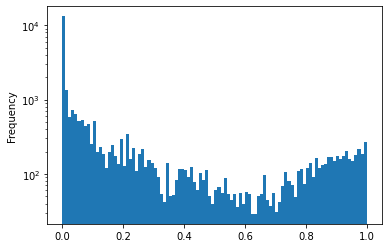

In [41]:
## Use the best n_gram to compute the chord rarity metric


all_chords = []
for chord in all_genres_en["chords"]:
    l = literal_eval(chord)
    all_chords += l
counter = Counter(all_chords)
max_value = counter.most_common(1)[0][1]
chord_rarity = {k:(1-i/(1+max_value)) for k, i in counter.items()}
chord_rarity = defaultdict(lambda: 1, chord_rarity)
# chord_rarity

def progression_rarity(progression: List[str], chord_rarity: Dict[str, float]):
    rarity = 1
    for chord in progression:
        rarity *= chord_rarity[chord]
    return rarity


all_genres_en["rarity"] = all_genres_en["best_ngram"].apply(lambda x: progression_rarity(x,chord_rarity))
all_genres_en["rarity"].plot(kind = "hist", bins = 100, logy = True, x = "rarity")


### 6. Data augmentation on rarer chord progressions


<AxesSubplot:ylabel='Frequency'>

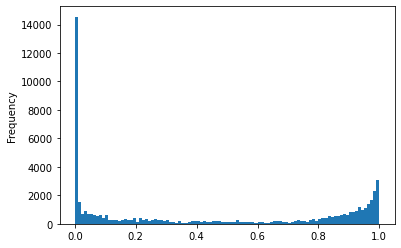

In [42]:
out_of_vocab = ["7sus","mMaj7", "min7", "6#11", "ma7", "maj9b5", "1", "m#", "add2", "major", "mmaj7", "6sus2", "7sus2", "+", "o", "Gbadd9/Ab" ]
manager = QualityManager()
[manager.set_quality(chord, (0,4,7,8)) for chord in out_of_vocab ]
# set_quality("7sus", (9,2))


def transpose_song(progression: List[str], transpose_val: int) -> Set[Tuple[str]]:
    roots = "A A# B C C# D D# E F F# G G#".split()
    prog_chords = []
    for chord in progression:
        try:
            c_chord = Chord(chord)
            prog_chords.append(c_chord)
        except:
            return {}
    possible_progs = set()
    for root in roots:
        temp = []
        for chord in prog_chords:
            new_chord = deepcopy(chord)
            new_chord.transpose(transpose_val, scale = root)
            temp.append(new_chord)
        possible_progs.add(tuple([chord.chord for chord in temp]))
    return possible_progs
        
def duplicate_chord_prog(chord_progression: List[str], duplicate_num: int):

    transpositions = []
    for i in range(1,12):
        transpositions += list(transpose_song(chord_progression, i))
    selection = random.sample(transpositions, min(len(transpositions), duplicate_num))
    return selection

def duplicate_song(song: pd.Series, num_duplicates: int = 10)->  pd.DataFrame:
    duplicates = []
    chords = song["best_ngram"]
    duplicates_chords = duplicate_chord_prog(chords, 100)
    if len(duplicates_chords) ==0:
        return pd.DataFrame()
    for i in range(len(duplicates_chords)):
        chosen_chords = duplicates_chords[i]
        new_song = deepcopy(song)
        new_song["best_ngram"] = chosen_chords
        new_song["rarity"] =progression_rarity(chosen_chords, chord_rarity)
        duplicates.append(new_song)
    df =pd.DataFrame(duplicates)#.sort_values(by=["rarity"],ascending= False)

    return df.iloc[:num_duplicates,:]



duplicates = []
all_genres_en[all_genres_en["rarity"] > 0.5].apply(lambda x: duplicates.append(duplicate_song(x,5)), axis = 1)
new_df = pd.concat(duplicates)
all_genres_en = pd.concat([new_df, all_genres_en])
all_genres_en["rarity"].plot(kind = "hist", bins = 100)



In [45]:
all_genres_en.to_csv('data/all_genres_en.csv', index = False)

all_genres_en["lyrics"] = all_genres_en["lyrics"].apply(preprocess_text)

all_genres_en.drop(columns= ["name", 'author', 'link', 'genre', 'language', 'ngrams', 'actual_name']).to_csv('model_data/lyrics_processed.csv', index = False)


In [21]:
pd.read_csv('data/all_genres_en.csv')

,name,author,link,lyrics,chords,genre,actual_name,language,ngrams,best_ngram,rarity
0,As Long As The Grass Shall Grow,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"As long, As the moon shall rise, As ...","['A', 'E', 'A', 'A', 'E', 'A', 'D', 'D', 'A', ...",Country,As Long As The Grass Shall Grow,en,"['A E A A', 'E A A E', 'A A E A', 'A E A D', '...","('A', 'A', 'D', 'E')",4.483044e-02
1,Delias Gone (ver 4),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Delia, oh, Delia Delia all my life\r\nIf I had...","['A', 'D', 'A', 'A7', 'D', 'B7', 'E', 'A', 'D'...",Country,Delias Gone,en,"['A D A A7', 'D A A7 D', 'A A7 D B7', 'A7 D B7...","('E', 'A', 'D', 'A')",4.483044e-02
2,Mean Eyed Cat,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['E', 'B7', 'E', 'A7', 'B7', 'E', 'E', 'B7', '...",Country,Mean Eyed Cat,en,"['E B7 E A7', 'B7 E A7 B7', 'E A7 B7 E', 'A7 B...","('E', 'A7', 'B7', 'E')",4.158067e-01
3,I Couldnt Keep From Crying,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"I SAW YOU WALKING BY HIS SIDE,\r\nHEARD YOU W...","['A', 'A7', 'D', 'A', 'E7', 'A', 'A7', 'D', 'A...",Country,I Couldnt Keep From Crying,en,"['A A7 D A', 'A7 D A E7', 'D A E7 A', 'A E7 A ...","('A', 'A7', 'D', 'A')",6.205614e-02
4,It Aint Me Babe (ver 3),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,Go 'way from my window leave at your own chose...,"['A', 'Bm', 'A', 'E', 'A', 'A', 'Bm', 'A', 'E'...",Country,It Aint Me Babe,en,"['A Bm A E', 'Bm A E A', 'A E A A', 'E A A Bm'...","('A', 'Bm', 'A', 'Bm')",1.631011e-01
...,...,...,...,...,...,...,...,...,...,...,...
29579,5150,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,Bruises don't heal overnight\r\nI'm a few sips...,"['C', 'G', 'D', 'Em', 'C', 'G', 'D', 'Em', 'C'...",Rock,5150,en,"['C G D Em', 'G D Em C', 'D Em C G', 'Em C G D...","('C', 'G', 'D', 'Em')",1.132251e-07
29580,Fake Love Dont Last,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,"I watched a movie scene, got déjà vu\r\n'Cause...","['Em', 'G', 'B', 'C', 'Em', 'G', 'B', 'C', 'Em...",Rock,Fake Love Dont Last,en,"['Em G B C', 'G B C Em', 'B C Em G', 'C Em G B...","('C', 'G', 'D', 'Em')",1.132251e-07
29581,Sid And Nancy,Machine Gun Kelly,https://tabs.ultimate-guitar.com/tab/machine-g...,I knew a girl who'd wear my t-shirts when she ...,"['D', 'F#m', 'E', 'D', 'F#m', 'E', 'D', 'F#m',...",Rock,Sid And Nancy,en,"['D F#m E D', 'F#m E D F#m', 'E D F#m E', 'D F...","('D', 'F#m', 'E', 'D')",4.758096e-02
29582,Forever,Stereophonics,https://tabs.ultimate-guitar.com/tab/stereopho...,Sun beats down on my mind on a friday morning...,"['G', 'C', 'G', 'C', 'G', 'C', 'G', 'C', 'D', ...",Rock,Forever,en,"['G C G C', 'C G C G', 'G C G C', 'C G C G', '...","('G', 'C', 'G', 'C')",3.904642e-13
